In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [4]:
import statsmodels.api as sm 
import pylab as py

In [5]:
import nibabel as nib
import random

For a given couple of pipeline, we have 1000 group analyses. The function **voxel_concat** takes as input the parameter values for the first and the second pipeline, stores all the statistical values contained within the mask in a list for each of the 1000 group analyses, and returns a concatenation of the 1000 lists obtained.

Since the resulting list of voxels obtained is very large (more than 150M statistical values) and using it for further observations can be very time-consuming, we only take a random sample of 1M values. The function **save_sample** takes a vector and a file name as input and stores a random sample (fixed with a seed) within a .txt file.

To avoid having to execute *voxel_concat* (which can take a long time) each time we need to extract the sample values, and thus simplify the re-execution of the notebook, we will use a function **voxel_concat_sample**, which takes as input parameter values for both pipelines, uses *voxel_concat* and *save_sample* as auxiliary functions to create the random sample file only if it does not exists already, and reads and returns the file content when the file exists.

In [6]:
def voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2):
    Vect_vox=[]
    smooth1=str(smooth1)
    smooth2=str(smooth2)
    reg1=str(reg1)
    reg2=str(reg2)
    der1=str(der1)
    der2=str(der2)
    for i in range(1000):
        fold='SLA'+str(i+1)+'_50'
        V0 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'spmT_0001.nii')).get_data().flatten()
        V1 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'mask.nii')).get_data().flatten()
        V0bis=V0[V1!=0].tolist()
        Vect_vox=Vect_vox+V0bis
    return Vect_vox;

In [7]:
def save_sample(data,name):
    random.seed(0)
    data_sample=random.sample(data,1000000)
    
    sample_file = open(name+".txt","w")
    for i in range(1000000):
        sample_file.write(str(data_sample[i]))
        if i!=999999:
            sample_file.write(" \n")
    sample_file.close()

In [8]:
def voxel_concat_sample(smooth1,reg1,der1,smooth2,reg2,der2):
    
    if not(os.path.isfile('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt')):
        vect_vox1 = voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2)
        save_sample(vect_vox1,'sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2))
        
    with open('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt',"r") as V0:
        filecontents=V0.readlines()
    Vect_vox_sample=[float(i) for i in filecontents]
    return Vect_vox_sample;

We created various functions to compare the distributions obtained with the expected distribution for a student law with df=98. We have **qqplot_stat**, which creates a classical Q-Q plot between the statistical values obtained and the expected quantiles ; **qqplot_pval**, which does the same but with the p-values $1-F(x_i)$ instead of the $x_i$ ; and **qqplot_frac**, which gives the proportion of elements $x$ with $1-F(x)$ superior to each $k/n$ where $n$ is the sample size.

We also created two functions based on **qqplot_pval**, **qqplot_pval_log1** and **qqplot_pval_log2** with logarithmic scales to have a better observations of the extreme p-values (lower values for log1 and higher values for log2). To do so, we used the distribution function $F$ instead of the survival function $1 - F$ for *qqplot_val_log2*.

Finally, we created a **Bland-Altman** function to do Bland-Altman plots giving the difference between the observed and expected p-values.

In [9]:
def qqplot_stat(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    quant = [dist.ppf(i,98) for i in p_th]
    line1, = ax2.plot(quant, sorted(np.array(data)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(quant, quant, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [32]:
def qqplot_pval(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]

    p_th_sub=[1000*t/len(data) for t in range(1,(len(data)+1)//1000)]
    
    conf_int_inf = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[0] for i in range(1,(len(data)+1)//1000)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[1] for i in range(1,(len(data)+1)//1000)]
    line1, = ax2.plot(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.plot(p_th_sub, conf_int_inf, '-')
    ax2.plot(p_th_sub, conf_int_sup, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [33]:
def qqplot_pval_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    conf_int_inf = [1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0] for i in range(1,len(data)+1)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1] for i in range(1,len(data)+1)]
    line1, = ax2.plot(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.plot(p_th, conf_int_inf, '-')
    ax2.plot(p_th, conf_int_sup, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [12]:
def qqplot_pval_log1(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [ ]:
def qqplot_pval_log1_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [13]:
def qqplot_pval_log2(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.cdf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ax2.set_title('Q-Q plot')
    plt.show()

In [ ]:
def qqplot_pval_log2_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.cdf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ax2.set_title('Q-Q plot')
    plt.show()

In [14]:
def qqplot_frac(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    p_obs_sort = sorted(dist.sf(np.array(data),98))
    
    k=0
    p_obs_2 = []
    for i in range(len(data)):
        while k < len(data) and p_obs_sort[k] < p_th[i]:
            k=k+1
        p_obs_2=p_obs_2+[(len(data)-k)/len(data)]
    p_obs_2=sorted(p_obs_2)
        
    
    line1, = ax2.plot(p_th, p_obs_2, '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [41]:
def Bland_Altman(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    p_obs = sorted(dist.sf(np.array(data),98))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]
    
    p_th_sub=[1000*t/len(data) for t in range(1,(len(data)+1)//1000)]
    
    conf_int_inf = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[0]-1000*i/len(data) for i in range(1,(len(data)+1)//1000)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[1]-1000*i/len(data) for i in range(1,(len(data)+1)//1000)]
        
    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.plot(p_th_sub,conf_int_inf)
    ax2.plot(p_th_sub,conf_int_sup)
    ax2.set_title('Bland-Altman')
    plt.show()

In [65]:
def Bland_Altman_log1(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta

    p_th = np.log([t/len(data) for t in range(1,len(data)+1)])
    p_obs = np.log(sorted(dist.sf(np.array(data),98)))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]
    
    p_th_sub=np.log([t/len(data) for t in range(1,10001)])
    
    conf_int_inf = [np.log(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-np.log(i/len(data)) for i in range(1,10001)]
    conf_int_sup = [np.log(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-np.log(i/len(data)) for i in range(1,10001)]
        
    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.plot(p_th_sub,conf_int_inf)
    ax2.plot(p_th_sub,conf_int_sup)
    ax2.set_title('Bland-Altman')
    plt.show()

9999

In [91]:
def Bland_Altman_log2(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta
    
    p_th = 1-np.log([1-t/len(data) for t in range(1,len(data)+1)])
    p_obs = 1-np.log(1-np.array(sorted(dist.sf(np.array(data),98))))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]

    p_th_sub=1-np.log([1-t/len(data) for t in range(len(data)-9999,len(data)+1)])

    conf_int_inf = [1-np.log(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-(1-np.log(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
    conf_int_sup = [1-np.log(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-(1-np.log(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
        
    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.plot(p_th_sub,conf_int_inf)
    ax2.plot(p_th_sub,conf_int_sup)
    ax2.set_title('Bland-Altman')
    plt.show()

# Mask Sizes

Since the 1000 group analyses have different mask sizes, voxel statistical values from a group analysis may be over-represented in the concatenation of all group analyses statistical values, which may be problematic since group analyses with higher statistical values tend to have a much bigger false positive rate. To ensure that this is not the case, we observe the mask sizes for all group analyses :

In [165]:
mask_size_list=[]

for i in range(1000):
    fold='SLA'+str(i+1)+'_50'
    V1 = nib.load(os.path.join('..', 'data',fold,'smooth_5_5','reg_6_6','der_1_1','mask.nii')).get_data().flatten()
    V1bis=V1[V1!=0].tolist()
    mask_size_list=mask_size_list+[len(V1bis)]

In [166]:
np.mean(mask_size_list)

155911.497

In [167]:
np.max(mask_size_list)

168936

(array([  9.,  34.,  53.,  20.,  45.,  99., 193., 259., 237.,  51.]),
 array([129419. , 133370.7, 137322.4, 141274.1, 145225.8, 149177.5,
        153129.2, 157080.9, 161032.6, 164984.3, 168936. ]),
 <a list of 10 Patch objects>)

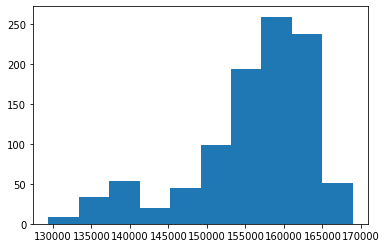

In [168]:
plt.hist(mask_size_list)

We can see that the biggest mask size is not much higher than the average.

# Examples

We give examples of use of the functions with the canonical pipeline versus the (5,0,0) pipeline (smoothing kernel FWHM=5mm, no motion regressors and no temporal derivatives of the HRF in the first-level analysis GLM).

In [197]:
Vect_vox_561_500_sample = voxel_concat_sample(5,6,1,5,0,0);

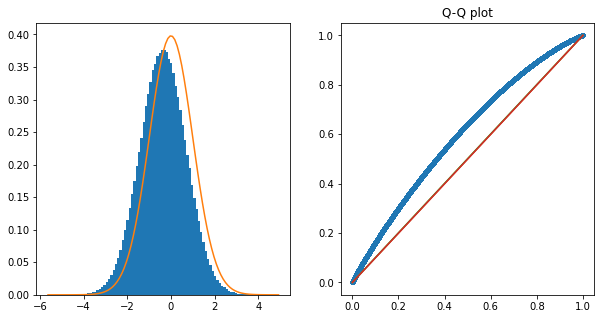

In [198]:
qqplot_pval(Vect_vox_561_500_sample,100)

In this example, it appears clearly that the p-values obtained are overall higher than expected, which is consistent with lower statistical values as we can observe on the first graph. The Bland-Altman plot matches with the difference between the scatter plot in blue and the y=x line in orange :

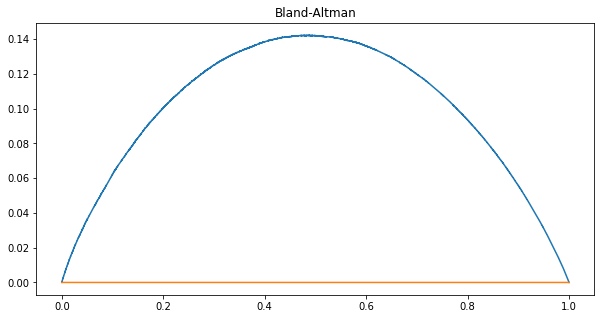

In [210]:
Bland_Altman(Vect_vox_561_500_sample)

Due to the very large sample size, the confidence interval can hardly be seen on the Q-Q plot for p-values. Here is what we observe with smaller sample sizes :

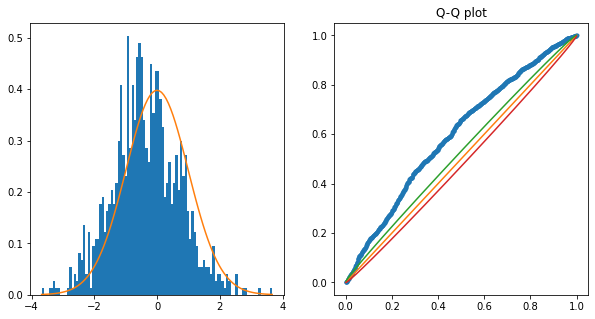

In [199]:
qqplot_pval(Vect_vox_561_500_sample[0:1000],100)

And with the logarithmic scale graphs :

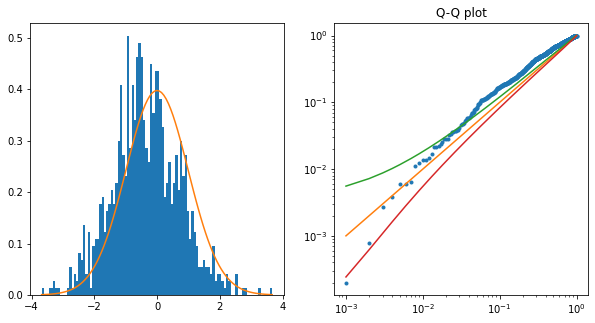

In [206]:
qqplot_pval_log1(Vect_vox_561_500_sample[0:1000],100)

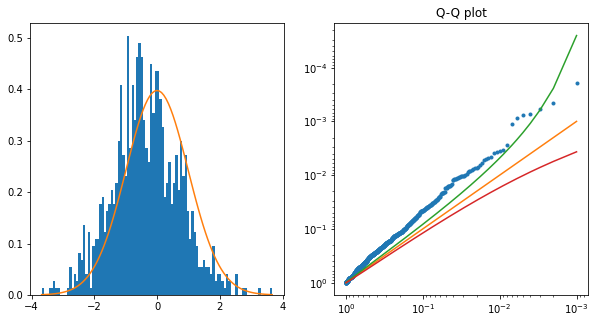

In [207]:
qqplot_pval_log2(Vect_vox_561_500_sample[0:1000],100)

We can also see the results for *qqplot_stat* and *qqplot_frac* :

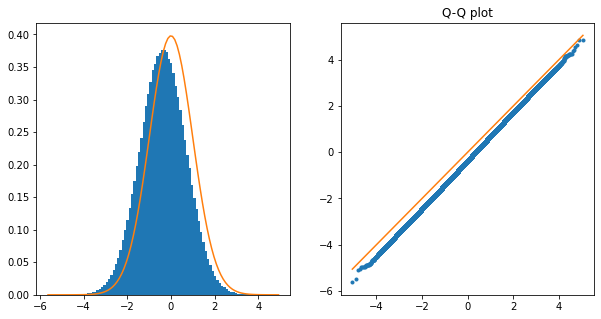

In [211]:
qqplot_stat(Vect_vox_561_500_sample,100)

# Other Pairs of Pipelines

We performed group analyses with the first group being processed with the canonical pipeline and the second group with a pipeline among a group of twelve pipelines, which we will refer to as : (5,0,0) ; (5,0,1) ; (5,6,0) ; (5,6,1) *(canonical pipeline)* ; (5,24,0) ; (5,24,1) ; (8,0,0) ; (8,0,1) ; (8,6,0) ; (8,6,1) ; (8,24,0) ; (8,24,1).

## Vector definitions

In [16]:
Vect_vox_561_500_sample = voxel_concat_sample(5,6,1,5,0,0);

In [17]:
Vect_vox_561_501_sample = voxel_concat_sample(5,6,1,5,0,1);

In [18]:
Vect_vox_561_560_sample = voxel_concat_sample(5,6,1,5,6,0);

In [19]:
Vect_vox_561_561_sample = voxel_concat_sample(5,6,1,5,6,1);

In [20]:
Vect_vox_561_5240_sample = voxel_concat_sample(5,6,1,5,24,0);

In [21]:
Vect_vox_561_5241_sample = voxel_concat_sample(5,6,1,5,24,1);

In [22]:
Vect_vox_561_800_sample = voxel_concat_sample(5,6,1,8,0,0);

In [23]:
Vect_vox_561_801_sample = voxel_concat_sample(5,6,1,8,0,1);

In [24]:
Vect_vox_561_860_sample = voxel_concat_sample(5,6,1,8,6,0);

In [25]:
Vect_vox_561_861_sample = voxel_concat_sample(5,6,1,8,6,1);

In [26]:
Vect_vox_561_8240_sample = voxel_concat_sample(5,6,1,8,24,0);

In [27]:
Vect_vox_561_8241_sample = voxel_concat_sample(5,6,1,8,24,1);

## Q-Q Plots for p-values & Bland-Altman Plots

### 5,6,1 vs 5,0,0

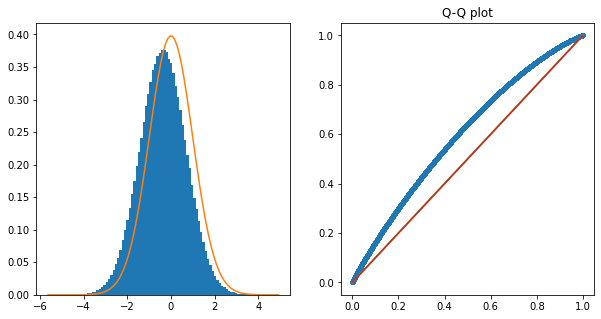

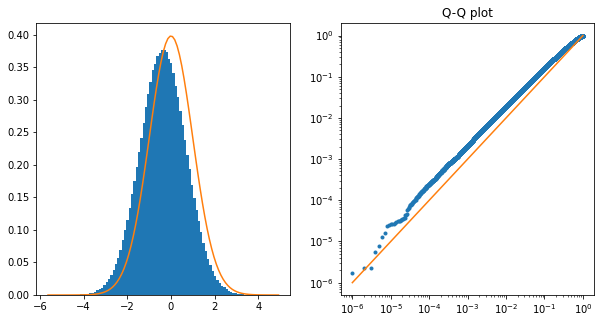

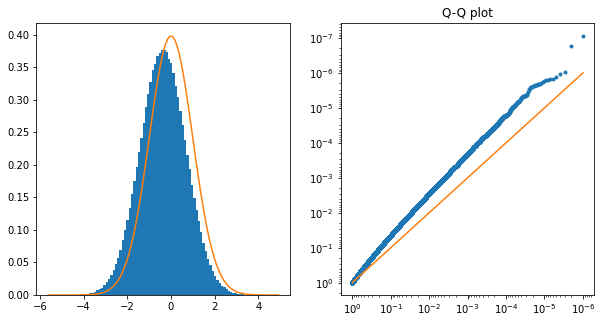

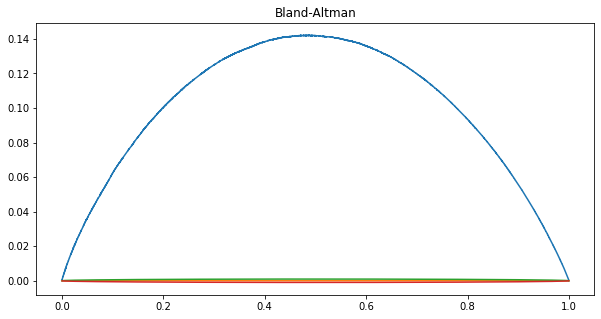

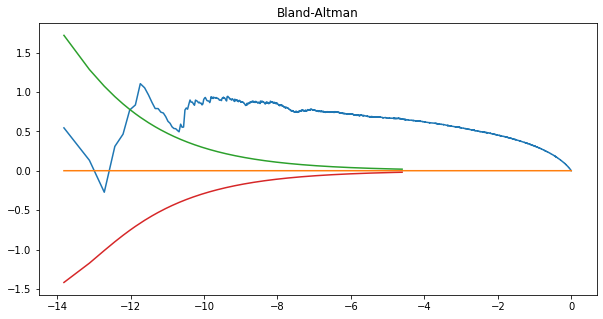

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


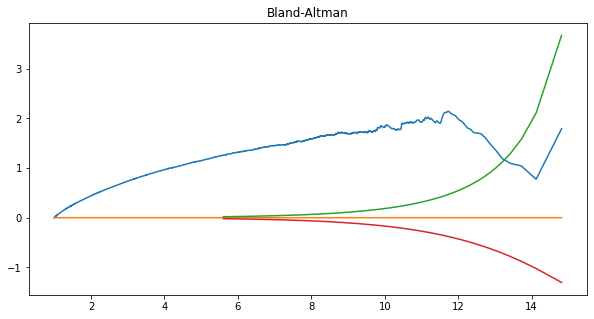

In [92]:
qqplot_pval(Vect_vox_561_500_sample,100)
qqplot_pval_log1(Vect_vox_561_500_sample,100)
qqplot_pval_log2(Vect_vox_561_500_sample,100)
Bland_Altman(Vect_vox_561_500_sample)
Bland_Altman_log1(Vect_vox_561_500_sample)
Bland_Altman_log2(Vect_vox_561_500_sample)

### 5,6,1 vs 5,0,1

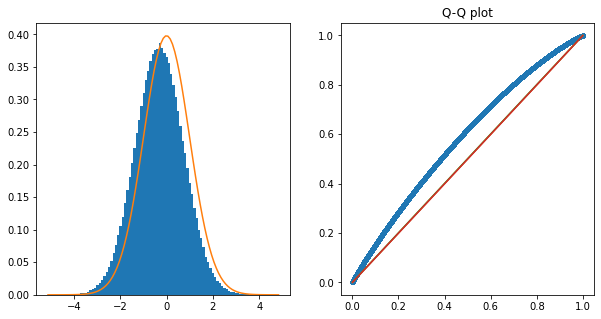

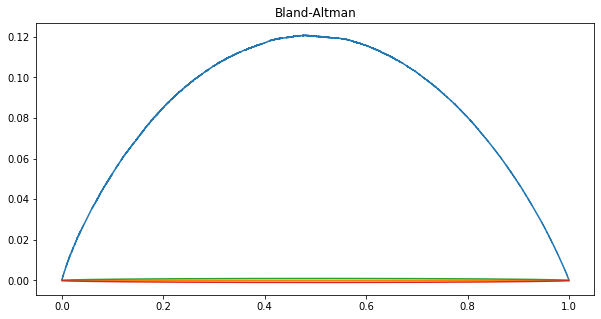

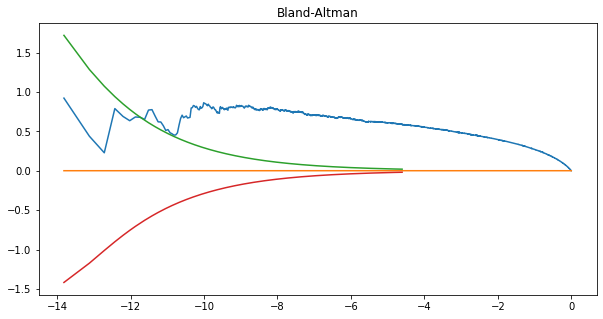

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


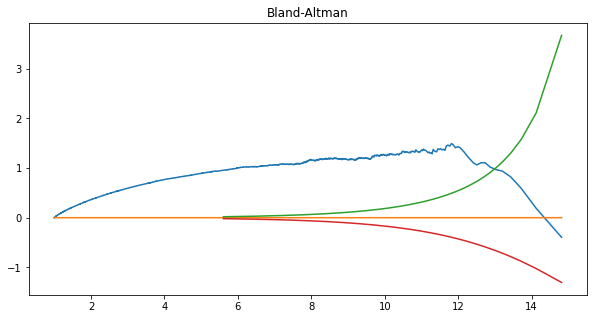

In [93]:
qqplot_pval(Vect_vox_561_501_sample,100)
Bland_Altman(Vect_vox_561_501_sample)
Bland_Altman_log1(Vect_vox_561_501_sample)
Bland_Altman_log2(Vect_vox_561_501_sample)

### 5,6,1 vs 5,6,0

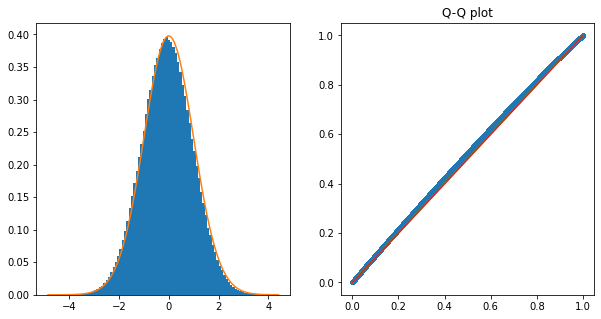

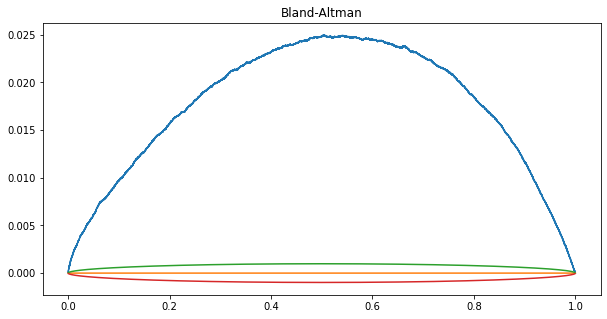

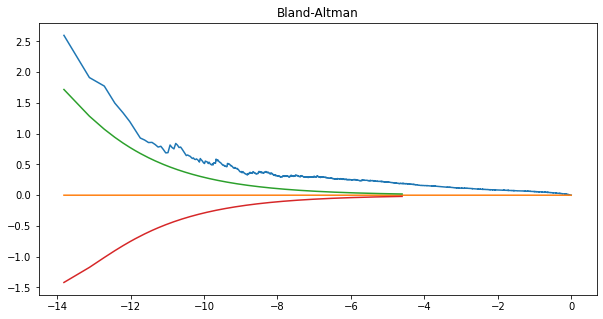

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


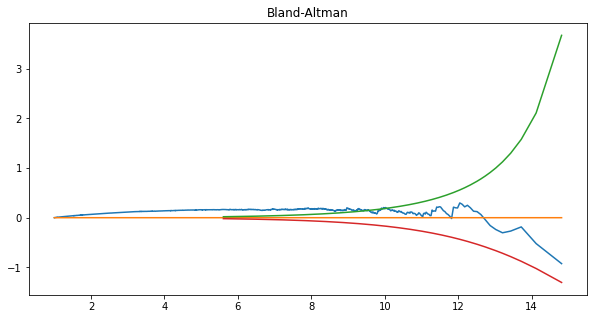

In [94]:
qqplot_pval(Vect_vox_561_560_sample,100)
Bland_Altman(Vect_vox_561_560_sample)
Bland_Altman_log1(Vect_vox_561_560_sample)
Bland_Altman_log2(Vect_vox_561_560_sample)

### 5,6,1 vs 5,6,1 (Sanity Check)

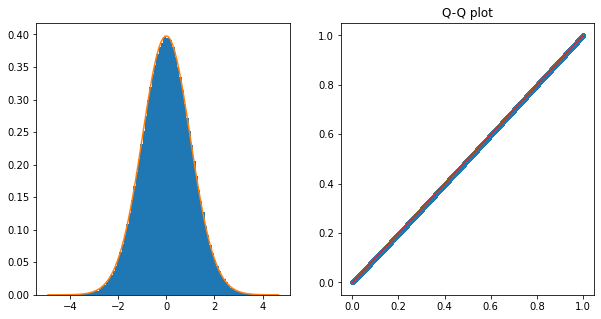

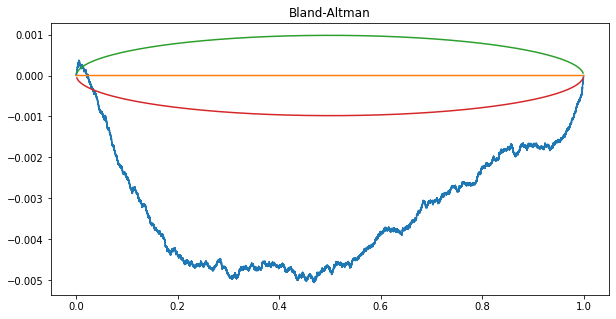

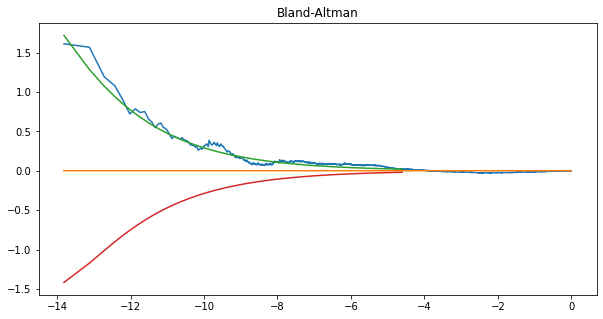

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


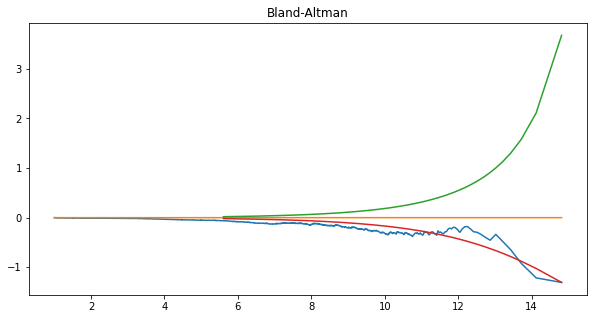

In [95]:
qqplot_pval(Vect_vox_561_561_sample,100)
Bland_Altman(Vect_vox_561_561_sample)
Bland_Altman_log1(Vect_vox_561_561_sample)
Bland_Altman_log2(Vect_vox_561_561_sample)

### 5,6,1 vs 5,24,0

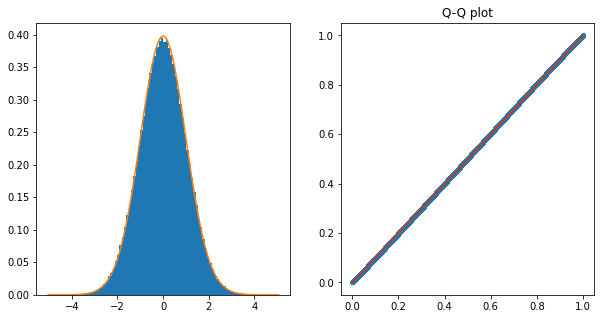

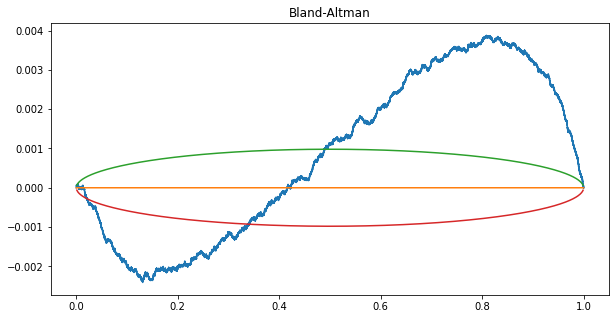

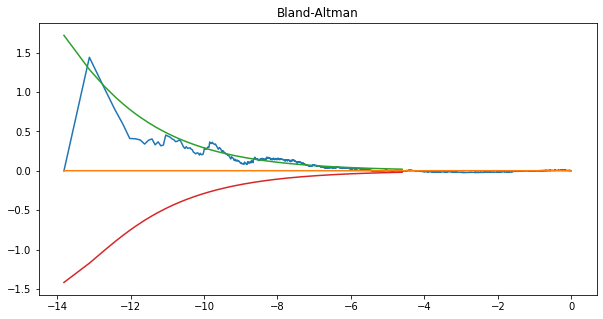

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


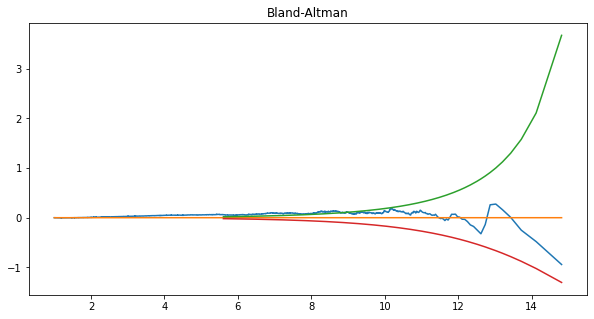

In [96]:
qqplot_pval(Vect_vox_561_5240_sample,100)
Bland_Altman(Vect_vox_561_5240_sample)
Bland_Altman_log1(Vect_vox_561_5240_sample)
Bland_Altman_log2(Vect_vox_561_5240_sample)

### 5,6,1 vs 5,24,1

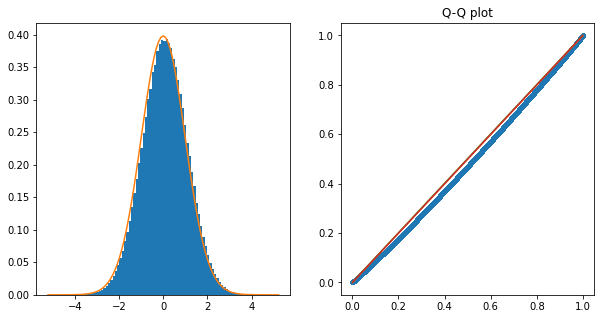

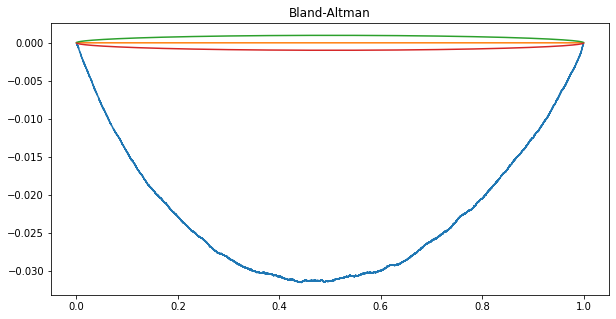

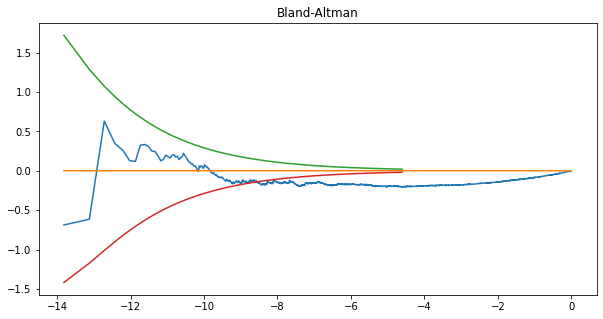

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


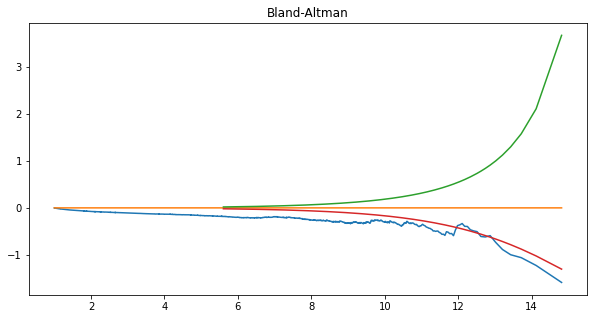

In [97]:
qqplot_pval(Vect_vox_561_5241_sample,100)
Bland_Altman(Vect_vox_561_5241_sample)
Bland_Altman_log1(Vect_vox_561_5241_sample)
Bland_Altman_log2(Vect_vox_561_5241_sample)

### 5,6,1 vs 8,0,0

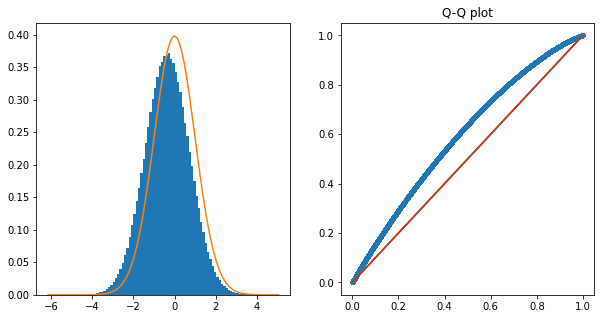

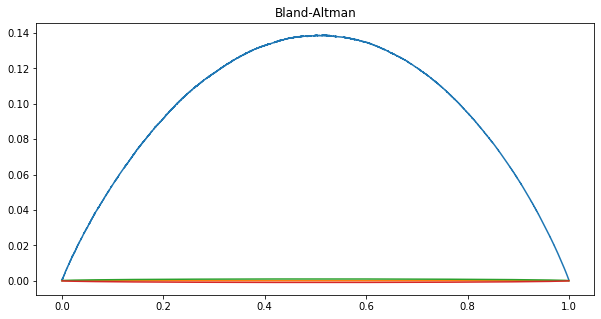

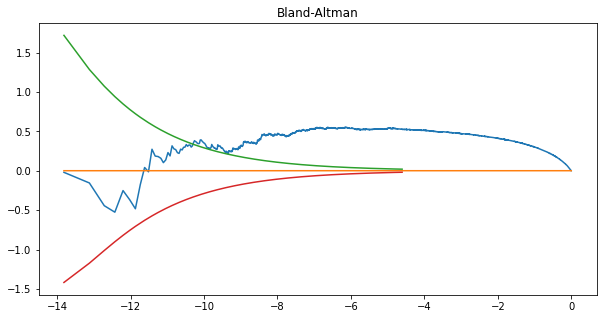

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


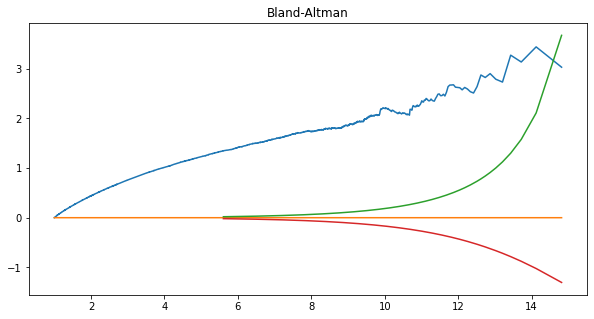

In [98]:
qqplot_pval(Vect_vox_561_800_sample,100)
Bland_Altman(Vect_vox_561_800_sample)
Bland_Altman_log1(Vect_vox_561_800_sample)
Bland_Altman_log2(Vect_vox_561_800_sample)

### 5,6,1 vs 8,0,1

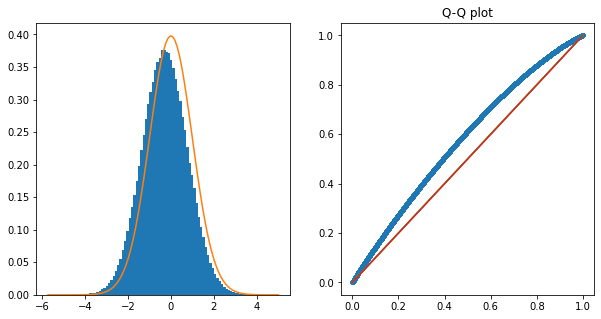

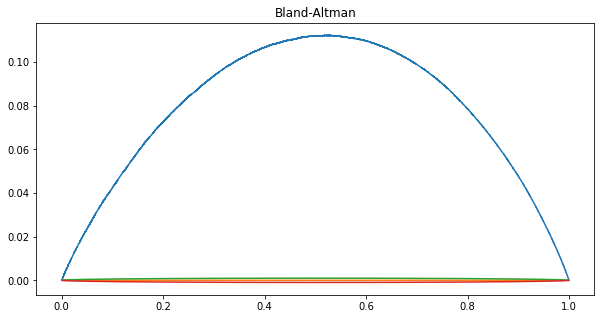

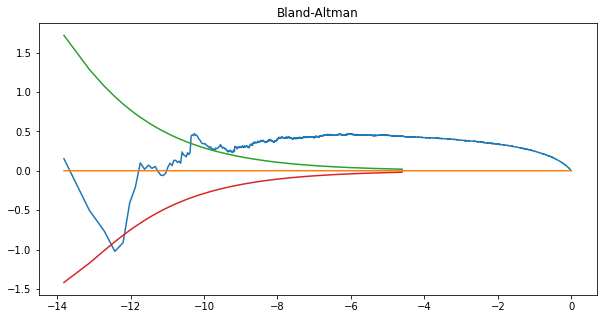

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


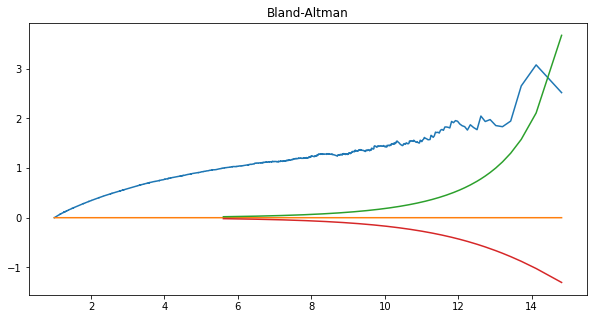

In [99]:
qqplot_pval(Vect_vox_561_801_sample,100)
Bland_Altman(Vect_vox_561_801_sample)
Bland_Altman_log1(Vect_vox_561_801_sample)
Bland_Altman_log2(Vect_vox_561_801_sample)

### 5,6,1 vs 8,6,0

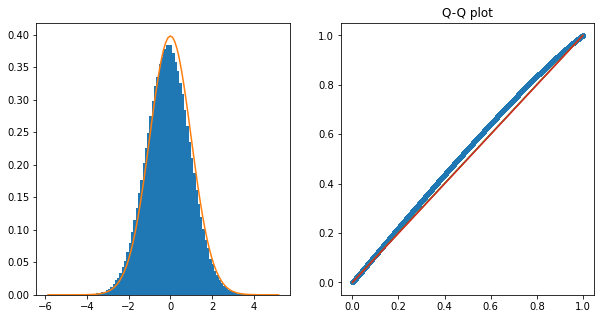

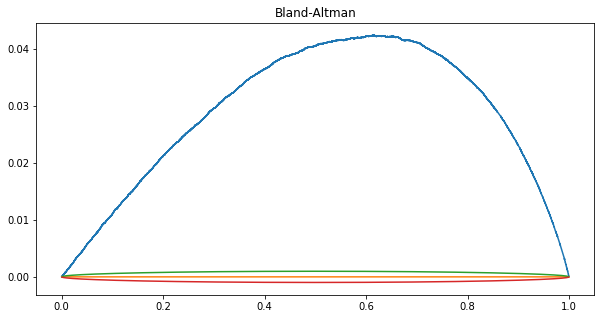

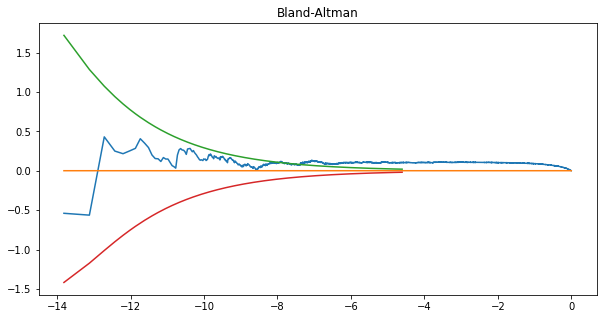

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


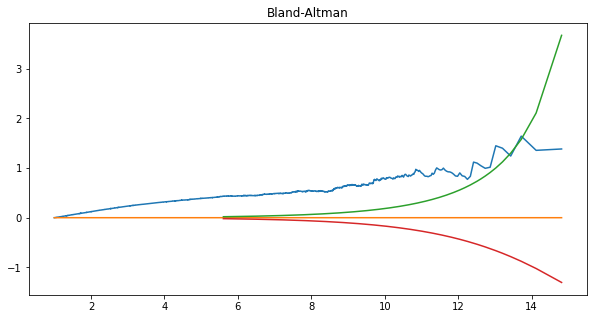

In [100]:
qqplot_pval(Vect_vox_561_860_sample,100)
Bland_Altman(Vect_vox_561_860_sample)
Bland_Altman_log1(Vect_vox_561_860_sample)
Bland_Altman_log2(Vect_vox_561_860_sample)

### 5,6,1 vs 8,6,1

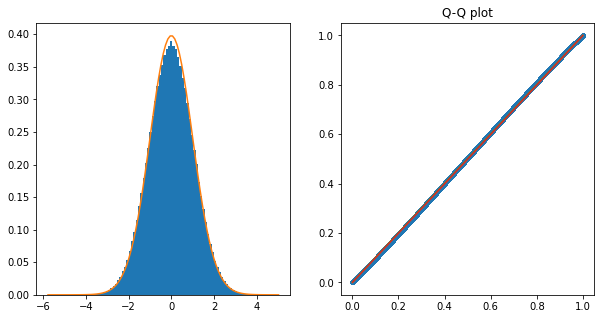

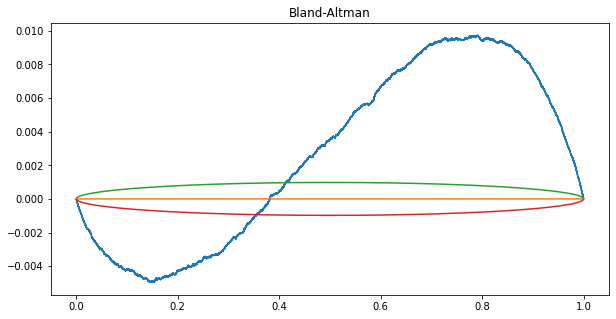

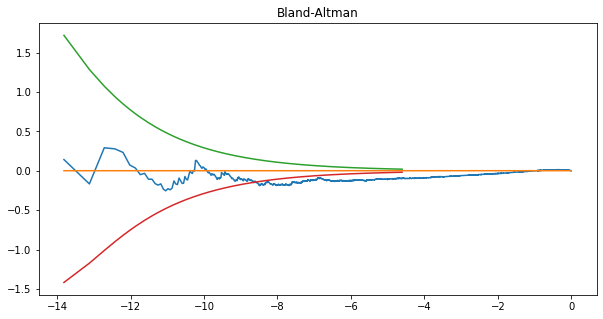

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


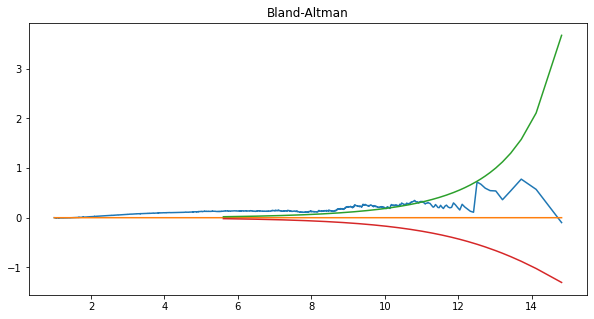

In [101]:
qqplot_pval(Vect_vox_561_861_sample,100)
Bland_Altman(Vect_vox_561_861_sample)
Bland_Altman_log1(Vect_vox_561_861_sample)
Bland_Altman_log2(Vect_vox_561_861_sample)

### 5,6,1 vs 8,24,0

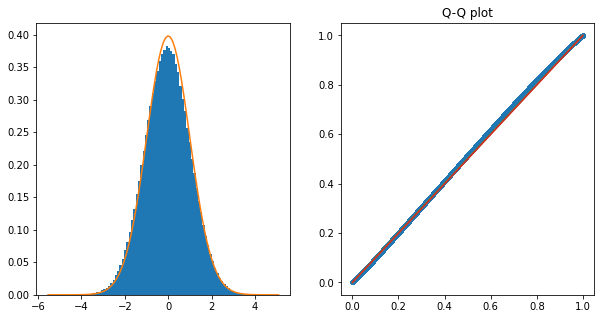

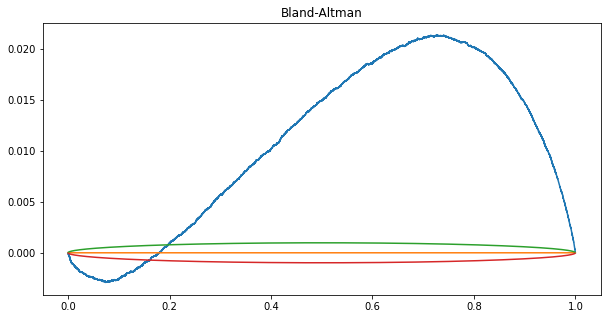

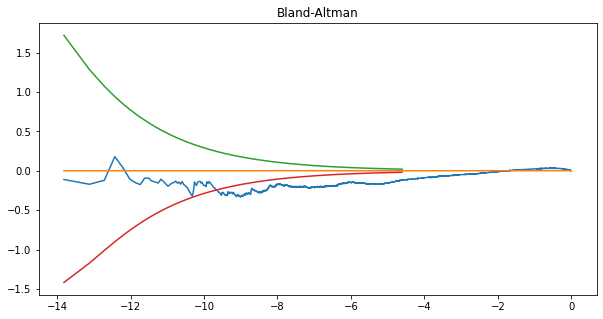

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


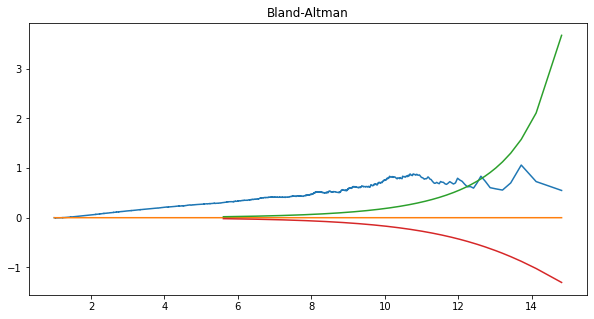

In [105]:
qqplot_pval(Vect_vox_561_8240_sample,100)
Bland_Altman(Vect_vox_561_8240_sample)
Bland_Altman_log1(Vect_vox_561_8240_sample)
Bland_Altman_log2(Vect_vox_561_8240_sample)

### 5,6,1 vs 8,24,1

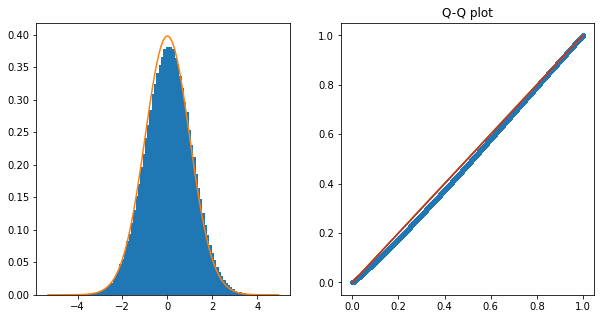

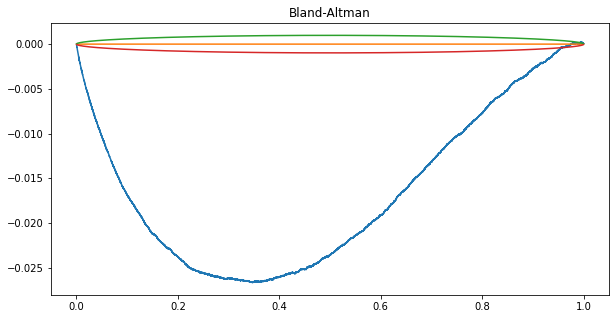

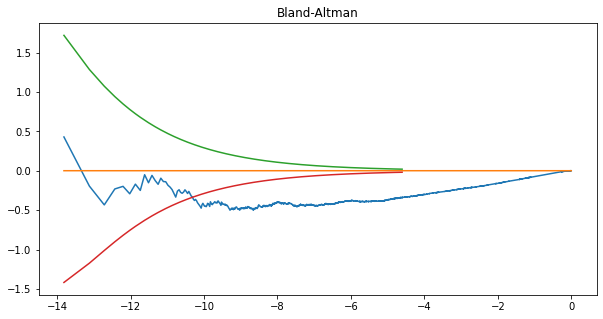

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


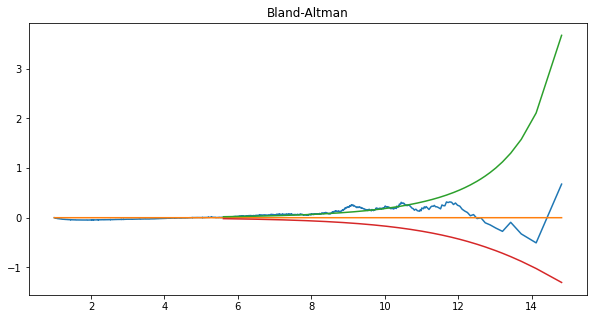

In [104]:
qqplot_pval(Vect_vox_561_8241_sample,100)
Bland_Altman(Vect_vox_561_8241_sample)
Bland_Altman_log1(Vect_vox_561_8241_sample)
Bland_Altman_log2(Vect_vox_561_8241_sample)